<a href="https://colab.research.google.com/github/DenizY98/pydemo/blob/main/Fallstudie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prozessoptimierung - Fallstudie

##PIP, OR-Tools und Pandas

In [1]:
# Importieren der benötigten Bibliotheken
!pip install -U -q pip
!pip install -q ortools
# Laden des Programms
from ortools.linear_solver import pywraplp
import pandas as pd
# Initialisieren des Solvers
solver = pywraplp.Solver.CreateSolver('SCIP')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 20.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
bigframes 0.19.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.1.4 which is incompatible.
google-colab 1.0.0 requir

In [2]:
! git clone https://github.com/AlexKressner/Industrielles_Management

Cloning into 'Industrielles_Management'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 110 (delta 7), reused 0 (delta 0), pack-reused 90
Receiving objects: 100% (110/110), 548.57 KiB | 7.41 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [3]:
path = "Industrielles_Management/Daten/Fallstudie/"

In [4]:
#dataframes laden aus Daten der CSV-Dateien
nachfrage_df = pd.read_csv(f"{path}/FLINK_Nachfrage.csv", sep=";", index_col=0) # Da Indizes in Datenquelle so festgelegt
standorte_df = pd.read_csv(f"{path}/FLINK_Standorte.csv", sep=";")

##Ziel:
Maximierung der bedienten Nachfrage innerhalb der vorgegebenen Lieferzeit und des Budgets.


##Daten:


###Indexmengen:
$ Q = \{q \mid q = (i,j), i \in \{0, \ldots, 12\}, j \in \{0, \ldots, 12\}\} $
Menge aller Quadranten $ q $ als $( i , j )$ Tupel


$ S = \{s \mid s \in \{0, \ldots, 9\}\} $
Menge aller potentieller DarkStores $ s $

In [5]:
Q = [(i, j) for i in range(nachfrage_df.shape[0]) for j in range(nachfrage_df.shape[1])]  # Menge aller Quadranten als (i, j) Paare
S = standorte_df['Potenzielle_Standorte'].to_list()  # Menge aller potentieller DarkStores

###Variablen:
$ x_s \in \{0,1\} \quad \forall s \in S $: Binärvariable, die angibt, ob am Standort $ s $ ein Dark Store eingerichtet wird $1$ oder nicht $0$.

$ y_{qs} \in \{0,1\} \quad \forall q \in Q, \forall s \in S $: Binärvariable, die angibt, ob der Standort $ s $ den Quadranten $ q (i,j) $ bedient $1$ oder nicht $0$.

In [6]:
x = {}
for s in S:
  x[s] = solver.BoolVar(f'x[{s}]')

In [7]:
y = {}
for s in S:
    for q in Q:
        y[q, s] = solver.NumVar(0,1,f'y[{q},{s}]')

###Dictionaries:
- Lagerumschlagsleistung je potentiellem Standort $ s $
- Errichtungskosten je potentiellem Standort $ s $
- Koordinaten je potentiellem Standort $ s $

In [8]:
#Standorte Dataframe
Lagerumschlagleistung = standorte_df.set_index('Potenzielle_Standorte')['Lagerumschlagleistung'].to_dict()
Errichtungskosten = standorte_df.set_index('Potenzielle_Standorte')['Errichtungskosten'].to_dict()
Koordinaten = standorte_df.set_index('Potenzielle_Standorte')[['i_Koordinate','j_Koordinate']].to_dict('index')

###Parameter:

$ D_q $: Nachfrage im Quadranten $ q $ als Bestellungen pro Tag.

$ L_s $: Lagerumschlagleistung des Standorts $ s $ als Bestellungen pro Tag.

$ C_s $: Kosten für die Einrichtung eines Dark Stores am Standort $ s $.

$ B $: Gesamtbudget für die Einrichtung von Dark Stores.

$ T $: Maximale Lieferzeit $10 Minuten$.

$ A $: Maximale Anzahl von Quadranten, die ein Fahrradkurier bedienen kann $5 Quadranten$.


In [11]:
D = {q: nachfrage_df.iat[q[0],q[1]] for q in Q} # Nachfrage im Quadranten q als Bestellungen pro Tag
L = {s: Lagerumschlagleistung[s] for s in S}  # Lagerumschlagleistung des Standorts s als Bestellungen pro Tag
C = {s: Errichtungskosten[s] for s in S}  # Kosten für die Einrichtung eines Dark Stores am Standort s
B = 1000000  # Gesamtbudget für die Einrichtung von Dark Stores
G = 25  # Geschwindigkeit in KM/H
T = 10  # Maximale Lieferzeit 10 Minuten
TF1= 3  # Zeitfresser in Minuten Warenbereitstellung AE
TF2= 1  # Zeitfresser in Minuten Warenübergabe beim Kunden
TV= (T-TF1-TF2) # Verbleibende Zeit abzüglich Zeitfressern
A = round((TV/2)/0.25*G/60, None) # max Reichweite in Quadranten für eine Richtung

###Restriktionen:
####Nachfragerestriktionen: $
\sum_{s \in S} y_{qs} \leq 1 \quad \forall q \in Q $
Jeder Quadrant wird von höchstens einem Dark Store bedient
####Budgetrestriktion: $
\sum_{s \in S} x_s \cdot C_s \leq B $
Ein Dark Store kann nur eingerichtet werden, wenn das Budget dies zulässt
####Lagerumschlagleistungsrestriktionen: $
\sum_{q \in Q} y_{qs} \cdot D_{q} \leq x_s \cdot L_s \quad \forall s \in S $
Die Nachfrage eines Quadranten kann nur bedient werden, wenn die Lagerumschlagleistung ausreicht und ein Dark Store vorhanden ist
####Reichweitenrestriktion für Fahrradkuriere: $
\text{Strecke}(s, q) > 5 \Rightarrow y_{qs} = 0 \quad \forall q \in Q, \forall s \in S $
Die Anzahl der von einem Fahrradkurier zurückgelegten Quadranten $Strecke$ darf nie größer $A$ sein, falls bestätigt, dass Quadrant $q$ von Standort $s$ beliefert wird.
<!--
####Liefergebietsrestriktionen: $
\sum_{q \in Q} y_{qs} \leq S_{\text{max}} \cdot x_s \quad \forall s \in S
$
Die Anzahl der von einem Dark Store bedienten Quadranten ist auf $ S_{\text{max}} $ beschränkt -->

$\text{Strecke}(s, q) > 5 \Rightarrow y_{qs} = 0 \quad \forall q \in Q, \forall s \in S $


In [14]:
# Nachfragerestriktionen
for q in Q:
    solver.Add(solver.Sum([y[q, s] for s in S]) <= 1)

# Budgetrestriktion
solver.Add(solver.Sum([x[s] * C[s] for s in S]) <= B)

#Lagerumschlagleistungsrestriktionen
for s in S:
    solver.Add(solver.Sum([y[q, s] * D[q] for q in Q]) <= x[s] * L[s])
# Reichweitenrestriktion für Fahrradkuriere
for s in S:
    for q in Q:
        # Berechnung der Manhattan-Distanz zwischen dem Standort s und dem Quadranten q
        distance = abs(Koordinaten[s]['i_Koordinate'] - q[0]) + abs(Koordinaten[s]['j_Koordinate'] - q[1])
        if distance > 5:
            solver.Add(y[q, s] == 0)


##Lösung:
###Zielfunktion:
Maximiere die gesamte bediente Nachfrage:

$ \text{Max} \sum_{sq} y_{qs} \cdot D_q $

In [15]:
# Zielfunktion
solver.Maximize(solver.Sum([y[q, s] * D[q] for q in Q for s in S]))
# Lösen des Modells
status = solver.Solve()

In [ ]:
# Ausgabe der Lösung
if status == pywraplp.Solver.OPTIMAL:
    print('Lösung gefunden:')
    for s in S:
        if x[s].solution_value() == 1:
            print(f'Standort {s} wird eingerichtet.')
            for q in Q:
                if y[q, s].solution_value() == 1:
                    print(f'Quadrant {q} wird von Standort {s} bedient.')
else:
    print('Keine optimale Lösung gefunden.')

In [17]:
print('Zielfunktionswert (Kosten) =', solver.Objective().Value())

Zielfunktionswert (Kosten) = 7482.000000000001


### Darstellung als Matrix, DF oder MatPlot

In [ ]:
import numpy as np
# Erstellen Sie eine leere Matrix der gleichen Größe wie Ihr Quadrantengitter
ergebnis_matrix = np.empty((14, 14), dtype=object)  # Größe angepasst, um Store i_Koordinate von 13 zu berücksichtigen

# Füllen Sie die Matrix mit den Ergebnissen Ihres Modells
for s in S:
    if x[s].solution_value() == 1:
        # Wenn ein Darkstore an diesem Standort errichtet wurde, markieren Sie die Zelle mit "DS"
        for q in Q:
            # Überprüfen Sie, ob der Quadrant von diesem Standort bedient wird
            if y[q, s].solution_value() == 1:
                # Wenn ja, fügen Sie die Nummer des beliefernden Darkstores hinzu
                ergebnis_matrix[q[0], q[1]] = str(s)

# Nachdem alle Quadranten bedient wurden, gehen Sie erneut über alle Standorte in S
for s in S:
    if x[s].solution_value() == 1:
        # Wenn ein Darkstore an diesem Standort errichtet wurde, markieren Sie die Zelle mit "DS"
        i, j = Koordinaten[s]['i_Koordinate'], Koordinaten[s]['j_Koordinate']
        if 0 <= i < 14 and 0 <= j < 14:  # Stellen Sie sicher, dass die Koordinaten innerhalb der Matrix liegen
            ergebnis_matrix[i, j] = "S" + str(s)

# Ausgabe der Ergebnismatrix
ergebnis_df = pd.DataFrame(ergebnis_matrix)
ergebnis_df

####Visualisierung

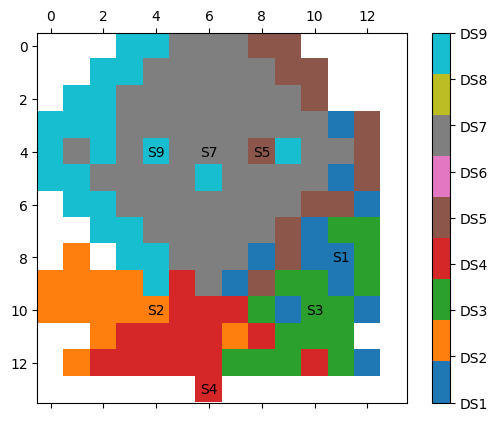

In [ ]:
import matplotlib.pyplot as plt

# Erstellen Sie eine Kopie der Ergebnismatrix, in der die Darkstores und Quadranten durch eindeutige numerische Werte repräsentiert werden
num_matrix = ergebnis_matrix.copy()
for i in range(14):
    for j in range(14):
        if num_matrix[i, j] is not None:
            if "S" in num_matrix[i, j]:
                num_matrix[i, j] = int(num_matrix[i, j].replace("S", ""))
            else:
                num_matrix[i, j] = int(num_matrix[i, j])

# Ersetzen Sie None-Werte durch einen speziellen numerischen Wert
num_matrix[num_matrix == None] = -1

# Konvertieren Sie die Matrix in eine Matrix von Gleitkommazahlen
num_matrix = num_matrix.astype(float)

# Ersetzen Sie den speziellen numerischen Wert durch NaN
num_matrix[num_matrix == -1] = np.nan

# Erstellen Sie eine Farbkarte, die jedem Darkstore eine eindeutige Farbe zuweist
cmap = plt.get_cmap('tab10', int(np.nanmax(num_matrix) - np.nanmin(num_matrix) + 1))

# Erstellen Sie eine Abbildung und eine Achse
fig, ax = plt.subplots()

# Erstellen Sie die Matrix als Bild
cax = ax.matshow(num_matrix, cmap=cmap)

# Erstellen Sie eine Farblegende
cbar = fig.colorbar(cax, ticks=np.arange(np.nanmin(num_matrix), np.nanmax(num_matrix)+2))  # +2 statt +1
labels = ['DS'+str(i) for i in range(int(np.nanmin(num_matrix)), int(np.nanmax(num_matrix))+2)]  # Beginnen Sie bei DS0
cbar.ax.set_yticklabels(labels[:len(cbar.get_ticks())])  # Stellen Sie sicher, dass die Anzahl der Labels mit der Anzahl der Ticks übereinstimmt

# Zeichnen Sie ein 'X' in die Zellen, die einen Darkstore repräsentieren
for s in S:
    if x[s].solution_value() == 1:
        i, j = Koordinaten[s]['i_Koordinate'], Koordinaten[s]['j_Koordinate']
        if 0 <= i < 14 and 0 <= j < 14:  # Stellen Sie sicher, dass die Koordinaten innerhalb der Matrix liegen
            plt.text(j, i, f'S{str(s)}', ha='center', va='center', color='black')

# Zeigen Sie das Bild an
plt.show()